## Modelos de Kaggle:


### Lo cuántico se nos va de las manos 💰
Manuel está busca de un buen ordenador cuántico, pero debido a su bajo presupuesto necesita buscar una alternativa ¿podrías ayudarlo?🙏🏻

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import toolbox_martin as tbm
import urllib.request
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor


In [2]:
# modelos de regresion
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [3]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("data/train.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    object 
 2   Product           912 non-null    object 
 3   TypeName          912 non-null    object 
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    object 
 6   Cpu               912 non-null    object 
 7   Ram               912 non-null    object 
 8   Memory            912 non-null    object 
 9   Gpu               912 non-null    object 
 10  OpSys             912 non-null    object 
 11  Weight            912 non-null    object 
 12  Price_in_euros    912 non-null    float64
dtypes: float64(2), int64(1), object(10)
memory usage: 92.8+ KB


In [5]:
df.sample()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
634,498,Toshiba,Portege X30-D-10L,Ultrabook,13.3,Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,32GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.05kg,2799.0


In [6]:
df.describe()

,laptop_ID,Inches,Price_in_euros
count,912.000000,912.000000,912.000000
mean,650.312500,14.981579,1111.724090
std,382.727748,1.436719,687.959172
min,2.000000,10.100000,174.000000
25%,324.750000,14.000000,589.000000
50%,636.500000,15.600000,978.000000
75%,982.250000,15.600000,1483.942500
max,1320.000000,18.400000,6099.000000


### Información de las variables

laptop_ID: Identificación única asignada a cada laptop.

Company: Nombre de la empresa fabricante de la laptop.

Product: Modelo específico de la laptop.

TypeName: Tipo de la laptop, como "Notebook," "Gaming," "Ultrabook," o "Workstation."

Inches: Tamaño de la pantalla en pulgadas.

ScreenResolution: Resolución de la pantalla, indicando la calidad y nitidez.

Cpu: Procesador central (CPU) de la laptop, incluyendo la marca y la velocidad.

Ram: Cantidad de memoria RAM en gigabytes.

Memory: Tipo y capacidad de almacenamiento, por ejemplo, "256GB SSD" o "1TB HDD."

Gpu: Unidad de procesamiento gráfico (GPU) de la laptop.

OpSys: Sistema operativo preinstalado en la laptop.

Weight: Peso de la laptop en kilogramos.

Price_in_euros: Precio de la laptop en euros.

### Analisis Dataframe

In [7]:
# Analizo el dataframe
tbm.analizar_df(df)

,Columna,Tipo,Cardinalidad,% Cardinalidad,Numero de nulos,% Nulos
0,laptop_ID,int64,912,100.000000,0,0.0
1,Company,object,19,2.083333,0,0.0
2,Product,object,480,52.631579,0,0.0
3,TypeName,object,6,0.657895,0,0.0
4,Inches,float64,17,1.864035,0,0.0
5,ScreenResolution,object,36,3.947368,0,0.0
6,Cpu,object,107,11.732456,0,0.0
7,Ram,object,9,0.986842,0,0.0
8,Memory,object,37,4.057018,0,0.0
9,Gpu,object,93,10.197368,0,0.0


#### Target

In [8]:
# Hacemos laptop_ID indice
df = pd.read_csv("data/train.csv", index_col=0)
df.index.name= None

In [9]:
target="Price_in_euros"

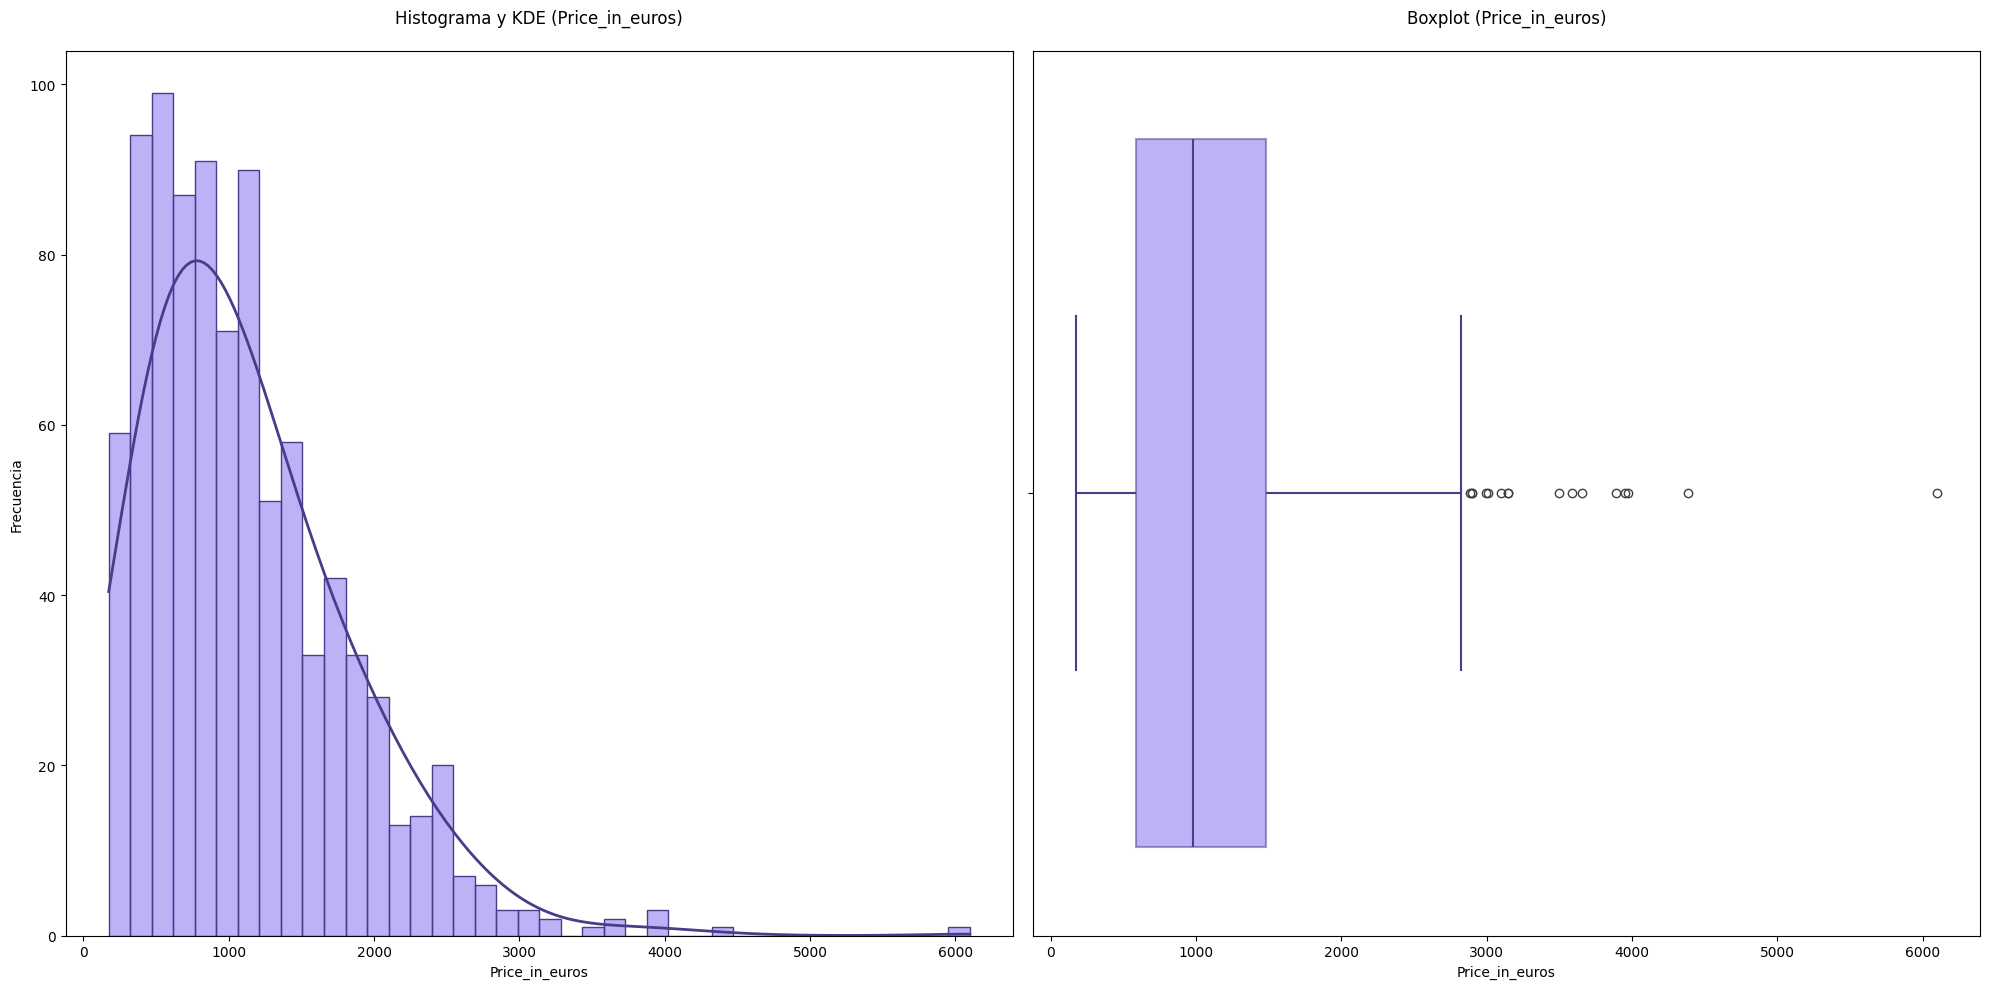

In [10]:
# Analisis de la target
tbm.histo_box(df, target)

In [11]:
df[target].loc[df[target] > 3000]

200     6099.00
731     3659.40
537     3012.77
924     3100.00
1081    3975.00
1249    3499.00
1151    3949.40
243     3890.00
667     3147.37
758     4389.00
982     3149.00
789     3588.80
Name: Price_in_euros, dtype: float64

In [12]:
df[target].loc[df[target] < 200]

21      191.9
295     199.0
32      199.0
1233    174.0
Name: Price_in_euros, dtype: float64

1. Presencia de outliers, que debemos eliminar
2. forma con apariencia normal

#### Features Numericas

In [13]:
# Corregimos peso
df["weight_kg"]=df['Weight'].str.replace('kg', '').astype(float)


#### Features Categoricas transformadas a numericas

In [14]:
# Crear una nueva columna 'cpu_p' e inicializarla con ceros
df['cpu_p'] = 0

# Intel
df.loc[df["Cpu"].str.contains("Intel Core i7"), "cpu_p"] = 7
df.loc[df["Cpu"].str.contains("Intel Core i5"), "cpu_p"] = 6
df.loc[df["Cpu"].str.contains("Intel Core i3"), "cpu_p"] = 4.5
df.loc[df["Cpu"].str.contains("Intel Core M"), "cpu_p"] = 5
df.loc[df["Cpu"].str.contains("Intel Pentium"), "cpu_p"] = 3
df.loc[df["Cpu"].str.contains("Intel Xeon"), "cpu_p"] = 10
df.loc[df["Cpu"].str.contains("Intel Atom"), "cpu_p"] = 1
df.loc[df["Cpu"].str.contains("Intel Celeron"), "cpu_p"] = 2
# AMD
df.loc[df["Cpu"].str.contains("AMD A12"), "cpu_p"] = 9
df.loc[df["Cpu"].str.contains("AMD A10"), "cpu_p"] = 8.5
df.loc[df["Cpu"].str.contains("AMD A9"), "cpu_p"] = 6.5
df.loc[df["Cpu"].str.contains("AMD A8"), "cpu_p"] = 5.5
df.loc[df["Cpu"].str.contains("AMD A6"), "cpu_p"] = 4
df.loc[df["Cpu"].str.contains("AMD E-Series"), "cpu_p"] = 2
df.loc[df["Cpu"].str.contains("AMD FX"), "cpu_p"] = 8
df.loc[df["Cpu"].str.contains("AMD Ryzen"), "cpu_p"] = 1



C:\Users\Martín Ámez Segovia\AppData\Local\Temp\ipykernel_4704\3906355772.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Cpu"].str.contains("Intel Core i3"), "cpu_p"] = 4.5


In [15]:
# Puntuamos Ram:
ordinal_encoder = OrdinalEncoder(categories=[['2GB', '4GB', '6GB', '8GB', '12GB', '16GB', '24GB', '32GB', '64GB']])
df['Ram_p'] = ordinal_encoder.fit_transform(df[['Ram']])

In [16]:
# funcion para extraer resolucion pantalla:
def extract_and_multiply(resolution):
    matches = re.findall(r'\d+', resolution)
    if matches:
        return int(matches[0]) * int(matches[1])
    else:
        return None

In [17]:
# Aplicar la función a la columna "ScreenResolution":
df['resolucion'] = df['ScreenResolution'].apply(extract_and_multiply)

In [18]:
# Reemplazar el valor 15360 por 8294400 en la columna 'resolucion' ya que multiplica 4 por 3840
df["resolucion"] = df["resolucion"].replace({15360: 8294400})

In [19]:
# Mapear los valores únicos de la columna 'resolution' a números
mapeo = {
1049088: 1,
1296000: 2,
1440000: 2.5,
2073600: 4,
2304000: 4.5,
3110400: 6,
3317760: 6.5,
3393024: 6.7,
3686400: 7.2,
3840000: 7.5,
4096000: 8,
4990464: 9,
5184000: 9.5,
5760000: 10.5,
8294400: 12.5,
}


# Aplicar el mapeo
df['screen_p1'] = df['resolucion'].map(mapeo)

In [20]:
# aplico el resto de funciones:
df["screen_p2"] = 0

for idx, resolution in enumerate(df["ScreenResolution"]):
    if "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "4k" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 2.5
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "full hd" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1.5
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "quad" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 2
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1
    elif "ips" in resolution.lower() and "full hd" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1
    elif "ips" in resolution.lower() and "quad" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1.5
    elif "touchscreen" in resolution.lower() and "full hd" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1
    elif "touchscreen" in resolution.lower() and "quad" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1.5
    elif "touchscreen" in resolution.lower() and "4k" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 2
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "full hd" in resolution.lower() and "quad" in resolution.lower() and "retina" in resolution.lower() and "4k" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 6
    elif "touchscreen" in resolution.lower() or "ips" in resolution.lower() or "full hd" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 0.5
    elif "quad" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1
    elif "retina" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 2
    elif "4k" in resolution.lower():
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 1.5
    else:
        df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx]


C:\Users\Martín Ámez Segovia\AppData\Local\Temp\ipykernel_4704\800941175.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 0.5
C:\Users\Martín Ámez Segovia\AppData\Local\Temp\ipykernel_4704\800941175.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df["screen_p2"].iloc[idx] = df["screen_p1"].iloc[idx] + 0.5


In [21]:
# cambios a memoria(pondero 2 sdd, 1,5 hybrid, 1.25 flash)
memory_order = {
    '2TB HDD': 2*1000,
    '1TB SSD +  1TB HDD': 1000*2+1000,
    '512GB SSD +  512GB SSD': 512*2+512*2,
    '512GB SSD +  1TB HDD': 512*2+1000,
    '512GB SSD +  2TB HDD': 512*2+2000,
    '256GB SSD +  2TB HDD': 256*2+2000,
    '256GB SSD +  256GB SSD': 256*2*2,
    '256GB SSD +  1TB HDD': 256*2+1000,
    '256GB SSD +  512GB HDD': 256*2+512,
    '240GB SSD': 240*2,
    '180GB SSD': 180*2,
    '128GB SSD +  2TB HDD': 128*2+2000,
    '128GB SSD +  1TB HDD': 128*2+1000,
    '128GB SSD +  256GB SSD': 128*2+256*2,
    '128GB SSD': 128*2,
    '64GB SSD': 60*2,
    '32GB SSD': 30*2,
    '1TB HDD +  1TB HDD': 2000,
    '1TB HDD': 1000,
    '1.0TB Hybrid': 1.5*1000,
    '512GB HDD ': 512,
    '32GB Flash Storage': 30*1.25,
    '16GB SSD': 16,
    '16GB Flash Storage': 16*1.25,
    '8GB SSD': 8,
    '512GB Flash Storage': 512*1.25,
    '256GB Flash Storage': 256*1.25,
    '128GB Flash Storage': 128*1.25,
    '64GB Flash Storage +  1TB HDD': 64*1.25+1000,
    '64GB Flash Storage': 64*1.25,
    '32GB HDD': 32,
    "1.0TB HDD":1000,
    "128GB HDD":128,
    "1TB SSD":1000*2,
    "500GB HDD":500,
    "256GB SSD":256*2,
    "508GB Hybrid":508*1.5,
    "256GB SSD +  500GB HDD":256*2+500,
    "512GB SSD":512*2,
    "512GB SSD +  256GB SSD":512*2+256*2,
    "512GB SSD +  1.0TB Hybrid":512*2+1000*1.5,
    "256GB SSD +  1.0TB Hybrid":256*2+1000*1.5

}

# Asignar el orden numérico a cada fila
df['memory_p'] = df['Memory'].map(memory_order)


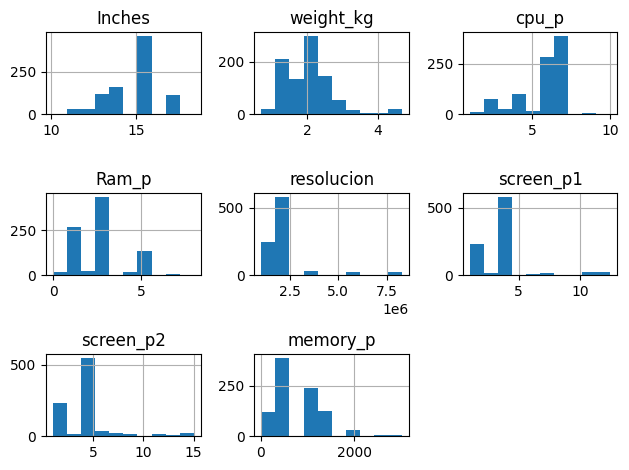

In [22]:
df.drop(target, axis=1).hist()
plt.tight_layout()

In [23]:
# Correlacion:
corr = df.corr(numeric_only=True)
np.abs(corr["Price_in_euros"]).sort_values(ascending=False)

Price_in_euros    1.000000
Ram_p             0.750285
cpu_p             0.573901
screen_p2         0.559984
screen_p1         0.554157
resolucion        0.493671
memory_p          0.430806
weight_kg         0.197086
Inches            0.071043
Name: Price_in_euros, dtype: float64

<Axes: >

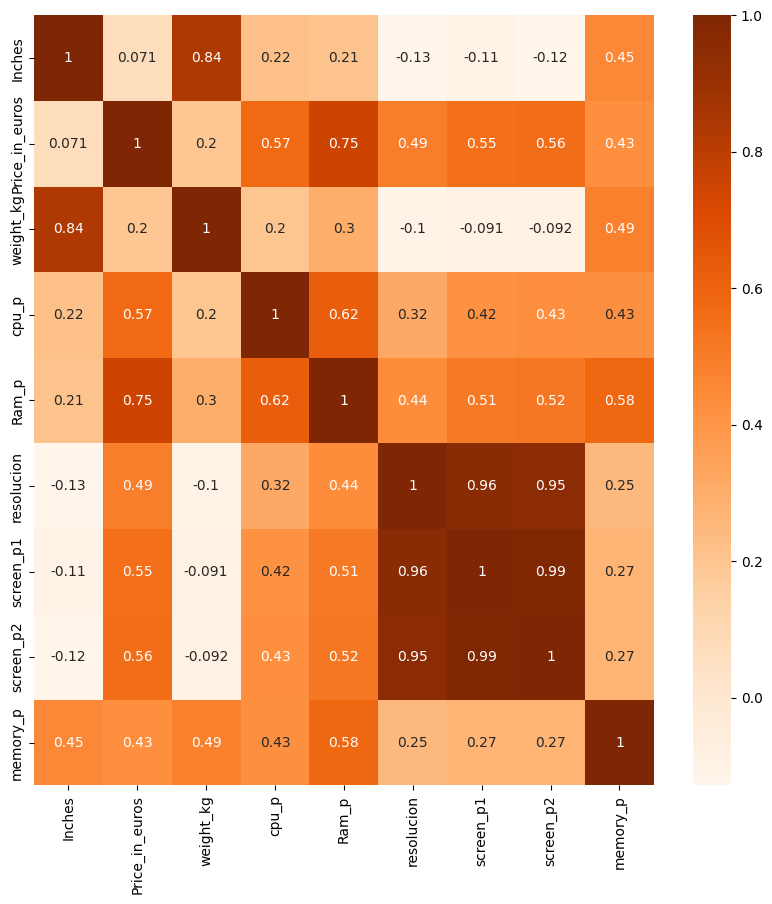

In [24]:
# mapa de calor:
plt.figure(figsize = (10,10))
sns.heatmap(corr, annot= True, cmap = "Oranges")

In [25]:
# Eliminamos variables cat, que no vayamos a usar
df_num=df.drop(["Product","screen_p1","resolucion","Weight","Memory","Cpu","ScreenResolution","Ram"], axis=1)
df_num=df_num.drop(["Gpu","TypeName"], axis=1)
df_num

,Company,Inches,OpSys,Price_in_euros,weight_kg,cpu_p,Ram_p,screen_p2,memory_p
755,HP,15.6,Windows 10,539.00,1.86,4.5,3.0,4.5,512.0
618,Dell,15.6,Windows 10,879.01,2.59,7.0,5.0,4.5,1000.0
909,HP,15.6,Windows 10,900.00,2.04,7.0,3.0,4.5,1000.0
2,Apple,13.3,macOS,898.94,1.34,6.0,3.0,2.0,160.0
286,Dell,15.6,Linux,428.00,2.25,4.5,1.0,4.5,1000.0
...,...,...,...,...,...,...,...,...,...
28,Dell,15.6,Windows 10,800.00,2.20,6.0,3.0,4.5,512.0
1160,HP,13.3,Windows 10,1629.00,1.48,6.0,3.0,5.0,512.0
78,Lenovo,15.6,No OS,519.00,2.20,6.0,3.0,4.5,2000.0
23,HP,15.6,No OS,258.00,1.86,2.0,1.0,1.0,500.0


In [26]:
#features_cat=["Company","TypeName","Gpu","OpSys"]
features_cat=["Company","OpSys"]

In [27]:
# todas las feat cat
df_encoded = pd.get_dummies(df_num, columns=features_cat, drop_first=True)
df_encoded

,Inches,Price_in_euros,weight_kg,cpu_p,Ram_p,screen_p2,memory_p,Company_Apple,Company_Asus,Company_Chuwi,...,Company_Vero,Company_Xiaomi,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
755,15.6,539.00,1.86,4.5,3.0,4.5,512.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
618,15.6,879.01,2.59,7.0,5.0,4.5,1000.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
909,15.6,900.00,2.04,7.0,3.0,4.5,1000.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,13.3,898.94,1.34,6.0,3.0,2.0,160.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True
286,15.6,428.00,2.25,4.5,1.0,4.5,1000.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,15.6,800.00,2.20,6.0,3.0,4.5,512.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1160,13.3,1629.00,1.48,6.0,3.0,5.0,512.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
78,15.6,519.00,2.20,6.0,3.0,4.5,2000.0,False,False,False,...,False,False,False,False,False,True,False,False,False,False
23,15.6,258.00,1.86,2.0,1.0,1.0,500.0,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [28]:
features_all=df_encoded.columns.to_list()
features_all.remove("Price_in_euros")

In [29]:
features_all

['Inches',
 'weight_kg',
 'cpu_p',
 'Ram_p',
 'screen_p2',
 'memory_p',
 'Company_Apple',
 'Company_Asus',
 'Company_Chuwi',
 'Company_Dell',
 'Company_Fujitsu',
 'Company_Google',
 'Company_HP',
 'Company_Huawei',
 'Company_LG',
 'Company_Lenovo',
 'Company_MSI',
 'Company_Mediacom',
 'Company_Microsoft',
 'Company_Razer',
 'Company_Samsung',
 'Company_Toshiba',
 'Company_Vero',
 'Company_Xiaomi',
 'OpSys_Chrome OS',
 'OpSys_Linux',
 'OpSys_Mac OS X',
 'OpSys_No OS',
 'OpSys_Windows 10',
 'OpSys_Windows 10 S',
 'OpSys_Windows 7',
 'OpSys_macOS']

In [30]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Inches              912 non-null    float64
 1   Price_in_euros      912 non-null    float64
 2   weight_kg           912 non-null    float64
 3   cpu_p               912 non-null    float64
 4   Ram_p               912 non-null    float64
 5   screen_p2           912 non-null    float64
 6   memory_p            912 non-null    float64
 7   Company_Apple       912 non-null    bool   
 8   Company_Asus        912 non-null    bool   
 9   Company_Chuwi       912 non-null    bool   
 10  Company_Dell        912 non-null    bool   
 11  Company_Fujitsu     912 non-null    bool   
 12  Company_Google      912 non-null    bool   
 13  Company_HP          912 non-null    bool   
 14  Company_Huawei      912 non-null    bool   
 15  Company_LG          912 non-null    bool   
 16  Company_Len

### Modelo Baseline / LinearRegressor (feat_num_2)

In [31]:
feat_num_2=["weight_kg","Inches"]

In [32]:
# Modelo LR 1
feat=['weight_kg',"cpu_p","Ram_p", 'Inches']
X=df.drop("Price_in_euros", axis=1)[feat]
y = df[target]
print(X.shape, y.shape)

# Train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Escalar los datos (normalización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_predict = model.predict(X_test_scaled)

# Calcular RMSE directamente
rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

(912, 4) (912,)
Root Mean Squared Error (RMSE): 484.78038791923757


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Modelo LinearRegression (feat_num_1)

In [33]:
# Modelo LR 1
X=df.drop("Price_in_euros", axis=1)[["weight_kg"]]
y = df['Price_in_euros'].copy()
print(X.shape, y.shape)

# Train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Escalar los datos (normalización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_predict = model.predict(X_test_scaled)

# Calcular RMSE directamente
rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')


(912, 1) (912,)
Root Mean Squared Error (RMSE): 733.554628719631


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
feat_num_1=["weight_kg"]

### Modelos distintos: feat_num_1 y feat_num_2

In [35]:
# Valores de entrada
X = df.drop("Price_in_euros", axis=1)[feat_num_1]
y = df['Price_in_euros'].copy()

# Train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Escalar los datos (normalización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar y entrenar modelos
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'SVR':SVR(),
    'RandomForest':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor()
}

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_predict = model.predict(X_test_scaled)

    # Calcular RMSE
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    print(f'{model_name} - Root Mean Squared Error (RMSE): {rmse}')

LinearRegression - Root Mean Squared Error (RMSE): 733.554628719631
DecisionTreeRegressor - Root Mean Squared Error (RMSE): 639.3911512797996


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LightGBM - Root Mean Squared Error (RMSE): 631.6868238669239


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost - Root Mean Squared Error (RMSE): 626.289149649722


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


SVR - Root Mean Squared Error (RMSE): 743.535163875564
RandomForest - Root Mean Squared Error (RMSE): 614.2653737979418
GradientBoostingRegressor - Root Mean Squared Error (RMSE): 635.543816079635


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
# Valores de entrada
X = df.drop("Price_in_euros", axis=1)[feat_num_2]
y = df['Price_in_euros'].copy()

# Train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Escalar los datos (normalización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar y entrenar modelos
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'SVR':SVR(),
    'RandomForest':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor()
}

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_predict = model.predict(X_test_scaled)

    # Calcular RMSE
    rmse = mean_squared_error(y_test, y_predict, squared=False)
    print(f'{model_name} - Root Mean Squared Error (RMSE): {rmse}')

c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LinearRegression - Root Mean Squared Error (RMSE): 748.5784298985218
DecisionTreeRegressor - Root Mean Squared Error (RMSE): 532.2426702684728
LightGBM - Root Mean Squared Error (RMSE): 569.368195494559
XGBoost - Root Mean Squared Error (RMSE): 548.8632644587983


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


SVR - Root Mean Squared Error (RMSE): 747.1308115690574
RandomForest - Root Mean Squared Error (RMSE): 535.298321957112
GradientBoostingRegressor - Root Mean Squared Error (RMSE): 563.8303286325703


c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Martín Ámez Segovia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Modelos distintos con cross_validation feat_num2

In [37]:
# Valores de entrada
X = df.drop("Price_in_euros", axis=1)[feat_num_2]
y = df[target].copy()

# Inicializar y entrenar modelos
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'SVR':SVR(),
    'RandomForest':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor()
}

# Escalar los datos (normalización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Puedes ajustar el número de divisiones según tus necesidades

for model_name, model in models.items():
    # Aplicar validación cruzada
    rmse_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Calcular RMSE promedio y desviación estándar
    rmse_avg = np.sqrt(-rmse_scores.mean())
    
    print(f'{model_name} - Cross-Validated RMSE: {rmse_avg}')

LinearRegression - Cross-Validated RMSE: 667.1800378889374
DecisionTreeRegressor - Cross-Validated RMSE: 583.0449866361937
LightGBM - Cross-Validated RMSE: 523.9522737366698
XGBoost - Cross-Validated RMSE: 560.9892437681846
SVR - Cross-Validated RMSE: 681.8215996491283
RandomForest - Cross-Validated RMSE: 543.6909293029493
GradientBoostingRegressor - Cross-Validated RMSE: 541.2302319197197


### Modelos distintos con cross_validation y todas las features

In [38]:
# Valores de entrada
X = df_encoded.drop("Price_in_euros", axis=1)[features_all]
y = df_encoded[target].copy()

# Inicializar y entrenar modelos
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'SVR':SVR(),
    'RandomForest':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor()
}

# Escalar los datos (normalización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Puedes ajustar el número de divisiones según tus necesidades

for model_name, model in models.items():
    # Aplicar validación cruzada
    rmse_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Calcular RMSE promedio y desviación estándar
    rmse_avg = np.sqrt(-rmse_scores.mean())
    
    print(f'{model_name} - Cross-Validated RMSE: {rmse_avg}')

LinearRegression - Cross-Validated RMSE: 7020863430506991.0
DecisionTreeRegressor - Cross-Validated RMSE: 403.86280390909457
LightGBM - Cross-Validated RMSE: 326.3113378698001
XGBoost - Cross-Validated RMSE: 313.434919589012
SVR - Cross-Validated RMSE: 686.6676223685505
RandomForest - Cross-Validated RMSE: 323.8042618256045
GradientBoostingRegressor - Cross-Validated RMSE: 316.9283090704424


### Modelos distintos con cross_validation y features tuneadas SOLO

In [39]:
# Valores de entrada
feat=['weight_kg',"cpu_p","Ram_p", 'Inches', 'screen_p2', 'memory_p']
X=df.drop("Price_in_euros", axis=1)[feat]
y = df[target]


# Inicializar y entrenar modelos
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'SVR':SVR(),
    'RandomForest':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor()
}

# Escalar los datos (normalización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Puedes ajustar el número de divisiones según tus necesidades

for model_name, model in models.items():
    # Aplicar validación cruzada
    rmse_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Calcular RMSE promedio y desviación estándar
    rmse_avg = np.sqrt(-rmse_scores.mean())
    
    print(f'{model_name} - Cross-Validated RMSE: {rmse_avg}')

LinearRegression - Cross-Validated RMSE: 421.7697739132372
DecisionTreeRegressor - Cross-Validated RMSE: 430.4085405822148
LightGBM - Cross-Validated RMSE: 343.7691180205737
XGBoost - Cross-Validated RMSE: 353.3485997209162
SVR - Cross-Validated RMSE: 671.8756206767415
RandomForest - Cross-Validated RMSE: 341.1157124677426
GradientBoostingRegressor - Cross-Validated RMSE: 348.59684710560447


### Modelos distintos con cross_validation y todas las features y sin outliers <3000

In [40]:
# Valores de entrada
df_encoded_all=df_encoded[df_encoded["Price_in_euros"]<3000]
X = df_encoded_all.drop("Price_in_euros", axis=1)[features_all]
y = df_encoded_all[target].copy()

# Inicializar y entrenar modelos
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'SVR':SVR(),
    'RandomForest':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor()
}

# Escalar los datos (normalización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Puedes ajustar el número de divisiones según tus necesidades

for model_name, model in models.items():
    # Aplicar validación cruzada
    rmse_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Calcular RMSE promedio y desviación estándar
    rmse_avg = np.sqrt(-rmse_scores.mean())
    
    print(f'{model_name} - Cross-Validated RMSE: {rmse_avg}')

LinearRegression - Cross-Validated RMSE: 6002077034513248.0
DecisionTreeRegressor - Cross-Validated RMSE: 358.5061502048173
LightGBM - Cross-Validated RMSE: 271.9778386577845
XGBoost - Cross-Validated RMSE: 281.24548840669166
SVR - Cross-Validated RMSE: 607.2743131964903
RandomForest - Cross-Validated RMSE: 285.54771283849664
GradientBoostingRegressor - Cross-Validated RMSE: 276.61491767805404


Me quedo con este ultimo grupo:

### Optimizacion hiperparametros modelos

In [41]:
from sklearn.model_selection import GridSearchCV

# Define los parámetros que deseas ajustar y sus posibles valores
param_grid = {
    'DecisionTreeRegressor': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'LightGBM': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200], "max_depth":[3,5,7]},
    'XGBoost': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200,300], "max_depth":[3,5,7]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'GradientBoostingRegressor': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200,300], 'max_depth': [3, 5, 7]}
}

# Inicializa y entrena los modelos
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

# Aplica validación cruzada con búsqueda de hiperparámetros
for model_name, model in models.items():
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=kf, scoring='neg_mean_squared_error')
        grid_search.fit(X_scaled, y)
        best_params = grid_search.best_params_
        best_score = np.sqrt(-grid_search.best_score_)
        
        print(f'Best Parameters for {model_name}: {best_params}')
        print(f'Best Cross-Validated RMSE for {model_name}: {best_score}\n')
    else:
        # Si el modelo no tiene parámetros específicos, realiza solo la validación cruzada
        rmse_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
        rmse_avg = np.sqrt(-rmse_scores.mean())
        print(f'{model_name} - Cross-Validated RMSE: {rmse_avg}')

Best Parameters for DecisionTreeRegressor: {'max_depth': 10, 'min_samples_split': 10}
Best Cross-Validated RMSE for DecisionTreeRegressor: 328.0377330105782

Best Parameters for LightGBM: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Cross-Validated RMSE for LightGBM: 271.8186514456435



Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Best Cross-Validated RMSE for XGBoost: 266.0978078770912

Best Parameters for RandomForest: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-Validated RMSE for RandomForest: 283.1018027574827

Best Parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Cross-Validated RMSE for GradientBoostingRegressor: 264.5058603889297



### Mejor modelo

De todos elijo GradientBoosting

In [73]:
# Mejores parámetros para Gradient Boosting obtenidos de la búsqueda de hiperparámetros
best_params_gb = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

# Inicializar el modelo Gradient Boosting con los mejores parámetros
best_model_gb = GradientBoostingRegressor(**best_params_gb)

# Ajustar el modelo con los datos de entrenamiento escalados
best_model_gb.fit(X_scaled, y)

GradientBoostingRegressor(max_depth=5)

### Prediccion

In [74]:
X_pred = pd.read_csv("data/test.csv", index_col=0)
X_pred.index.name=None

In [75]:
X_pred.head(5)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


#### Realizamos mismos cambios

In [76]:
# Hacemos todos los cambios

In [77]:
# Corregimos peso
X_pred["weight_kg"]=X_pred['Weight'].str.replace('kg', '').astype(float)

In [78]:
# Crear una nueva columna 'cpu_p' e inicializarla con ceros
X_pred['cpu_p'] = 0

# Intel
X_pred.loc[X_pred["Cpu"].str.contains("Intel Core i7"), "cpu_p"] = 7
X_pred.loc[X_pred["Cpu"].str.contains("Intel Core i5"), "cpu_p"] = 6
X_pred.loc[X_pred["Cpu"].str.contains("Intel Core i3"), "cpu_p"] = 4.5
X_pred.loc[X_pred["Cpu"].str.contains("Intel Core M"), "cpu_p"] = 5
X_pred.loc[X_pred["Cpu"].str.contains("Intel Pentium"), "cpu_p"] = 3
X_pred.loc[X_pred["Cpu"].str.contains("Intel Xeon"), "cpu_p"] = 10
X_pred.loc[X_pred["Cpu"].str.contains("Intel Atom"), "cpu_p"] = 1
X_pred.loc[X_pred["Cpu"].str.contains("Intel Celeron"), "cpu_p"] = 2
# AMD
X_pred.loc[X_pred["Cpu"].str.contains("AMD A12"), "cpu_p"] = 9
X_pred.loc[X_pred["Cpu"].str.contains("AMD A10"), "cpu_p"] = 8.5
X_pred.loc[X_pred["Cpu"].str.contains("AMD A9"), "cpu_p"] = 6.5
X_pred.loc[X_pred["Cpu"].str.contains("AMD A8"), "cpu_p"] = 5.5
X_pred.loc[X_pred["Cpu"].str.contains("AMD A6"), "cpu_p"] = 4
X_pred.loc[X_pred["Cpu"].str.contains("AMD E-Series"), "cpu_p"] = 2
X_pred.loc[X_pred["Cpu"].str.contains("AMD FX"), "cpu_p"] = 8
X_pred.loc[X_pred["Cpu"].str.contains("AMD Ryzen"), "cpu_p"] = 1

C:\Users\Martín Ámez Segovia\AppData\Local\Temp\ipykernel_4704\1538571285.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_pred.loc[X_pred["Cpu"].str.contains("Intel Core i3"), "cpu_p"] = 4.5


In [79]:
# Puntuamos Ram:
ordinal_encoder = OrdinalEncoder(categories=[['2GB', '4GB', '6GB', '8GB', '12GB', '16GB', '24GB', '32GB', '64GB']])
X_pred['Ram_p'] = ordinal_encoder.fit_transform(X_pred[['Ram']])

In [80]:
# Aplicar la función a la columna "ScreenResolution":
X_pred['resolucion'] = X_pred['ScreenResolution'].apply(extract_and_multiply)

In [81]:
# Reemplazar el valor 15360 por 8294400 en la columna 'resolucion' ya que multiplica 4 por 3840
X_pred["resolucion"] = X_pred["resolucion"].replace({15360: 8294400})

In [82]:
# Mapear los valores únicos de la columna 'resolution' a números
mapeo = {
1049088: 1,
1296000: 2,
1440000: 2.5,
2073600: 4,
2304000: 4.5,
3110400: 6,
3317760: 6.5,
3393024: 6.7,
3686400: 7.2,
3840000: 7.5,
4096000: 8,
4990464: 9,
5184000: 9.5,
5760000: 10.5,
8294400: 12.5,
}


# Aplicar el mapeo
X_pred['screen_p1'] = X_pred['resolucion'].map(mapeo)
# aplico el resto de funciones:
X_pred["screen_p2"] = 0

for idx, resolution in enumerate(X_pred["ScreenResolution"]):
    if "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "4k" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 2.5
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "full hd" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1.5
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "quad" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 2
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1
    elif "ips" in resolution.lower() and "full hd" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1
    elif "ips" in resolution.lower() and "quad" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1.5
    elif "touchscreen" in resolution.lower() and "full hd" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1
    elif "touchscreen" in resolution.lower() and "quad" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1.5
    elif "touchscreen" in resolution.lower() and "4k" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 2
    elif "touchscreen" in resolution.lower() and "ips" in resolution.lower() and "full hd" in resolution.lower() and "quad" in resolution.lower() and "retina" in resolution.lower() and "4k" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 6
    elif "touchscreen" in resolution.lower() or "ips" in resolution.lower() or "full hd" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 0.5
    elif "quad" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1
    elif "retina" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 2
    elif "4k" in resolution.lower():
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 1.5
    else:
        X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx]


C:\Users\Martín Ámez Segovia\AppData\Local\Temp\ipykernel_4704\4152054260.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 0.5
C:\Users\Martín Ámez Segovia\AppData\Local\Temp\ipykernel_4704\4152054260.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_pred["screen_p2"].iloc[idx] = X_pred["screen_p1"].iloc[idx] + 0.5


In [83]:
# cambios a memoria(pondero 2 sdd, 1,5 hybrid, 1.25 flash)
memory_order = {
    '2TB HDD': 2*1000,
    '1TB SSD +  1TB HDD': 1000*2+1000,
    '512GB SSD +  512GB SSD': 512*2+512*2,
    '512GB SSD +  1TB HDD': 512*2+1000,
    '512GB SSD +  2TB HDD': 512*2+2000,
    '256GB SSD +  2TB HDD': 256*2+2000,
    '256GB SSD +  256GB SSD': 256*2*2,
    '256GB SSD +  1TB HDD': 256*2+1000,
    '256GB SSD +  512GB HDD': 256*2+512,
    '240GB SSD': 240*2,
    '180GB SSD': 180*2,
    '128GB SSD +  2TB HDD': 128*2+2000,
    '128GB SSD +  1TB HDD': 128*2+1000,
    '128GB SSD +  256GB SSD': 128*2+256*2,
    '128GB SSD': 128*2,
    '64GB SSD': 60*2,
    '32GB SSD': 30*2,
    '1TB HDD +  1TB HDD': 2000,
    '1TB HDD': 1000,
    '1.0TB Hybrid': 1.5*1000,
    '512GB HDD ': 512,
    '32GB Flash Storage': 30*1.25,
    '16GB SSD': 16,
    '16GB Flash Storage': 16*1.25,
    '8GB SSD': 8,
    '512GB Flash Storage': 512*1.25,
    '256GB Flash Storage': 256*1.25,
    '128GB Flash Storage': 128*1.25,
    '64GB Flash Storage +  1TB HDD': 64*1.25+1000,
    '64GB Flash Storage': 64*1.25,
    '32GB HDD': 32,
    "1.0TB HDD":1000,
    "128GB HDD":128,
    "1TB SSD":1000*2,
    "500GB HDD":500,
    "256GB SSD":256*2,
    "508GB Hybrid":508*1.5,
    "256GB SSD +  500GB HDD":256*2+500,
    "512GB SSD":512*2,
    "512GB SSD +  256GB SSD":512*2+256*2,
    "512GB SSD +  1.0TB Hybrid":512*2+1000*1.5,
    "256GB SSD +  1.0TB Hybrid":256*2+1000*1.5

}

# Asignar el orden numérico a cada fila
X_pred['memory_p'] = X_pred['Memory'].map(memory_order)

In [84]:
# Eliminamos variables cat, que no vayamos a usar
X_pred_num=X_pred.drop(["Product","screen_p1","resolucion","Weight","Memory","Cpu","ScreenResolution","Ram"], axis=1)
X_pred_num=X_pred_num.drop(["TypeName","Gpu"], axis=1)
X_pred_num

,Company,Inches,OpSys,weight_kg,cpu_p,Ram_p,screen_p2,memory_p
209,Lenovo,15.6,No OS,2.400,7.0,5.0,4.5,1024.0
1281,Acer,15.6,Linux,2.400,2.0,1.0,1.0,500.0
1168,Lenovo,15.6,No OS,1.900,4.5,1.0,1.0,1000.0
1231,Dell,15.6,Windows 10,2.191,6.0,3.0,5.5,512.0
1020,HP,14.0,Windows 10,1.950,6.0,1.0,4.5,512.0
...,...,...,...,...,...,...,...,...
820,MSI,17.3,Windows 10,2.900,7.0,5.0,4.5,2024.0
948,Toshiba,14.0,Windows 10,1.470,6.0,1.0,5.0,256.0
483,Dell,15.6,Windows 10,1.780,7.0,3.0,4.5,512.0
1017,HP,14.0,Windows 10,1.640,6.0,1.0,1.0,500.0


In [85]:
# todas las feat cat
X_pred_encoded = pd.get_dummies(X_pred_num, columns=features_cat, drop_first=True)
X_pred_encoded

,Inches,weight_kg,cpu_p,Ram_p,screen_p2,memory_p,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,Company_Toshiba,Company_Vero,Company_Xiaomi,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
209,15.6,2.400,7.0,5.0,4.5,1024.0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1281,15.6,2.400,2.0,1.0,1.0,500.0,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1168,15.6,1.900,4.5,1.0,1.0,1000.0,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1231,15.6,2.191,6.0,3.0,5.5,512.0,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1020,14.0,1.950,6.0,1.0,4.5,512.0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,17.3,2.900,7.0,5.0,4.5,2024.0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
948,14.0,1.470,6.0,1.0,5.0,256.0,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
483,15.6,1.780,7.0,3.0,4.5,512.0,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1017,14.0,1.640,6.0,1.0,1.0,500.0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [86]:
X_pred_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Inches              391 non-null    float64
 1   weight_kg           391 non-null    float64
 2   cpu_p               391 non-null    float64
 3   Ram_p               391 non-null    float64
 4   screen_p2           391 non-null    float64
 5   memory_p            391 non-null    float64
 6   Company_Apple       391 non-null    bool   
 7   Company_Asus        391 non-null    bool   
 8   Company_Chuwi       391 non-null    bool   
 9   Company_Dell        391 non-null    bool   
 10  Company_Fujitsu     391 non-null    bool   
 11  Company_Google      391 non-null    bool   
 12  Company_HP          391 non-null    bool   
 13  Company_LG          391 non-null    bool   
 14  Company_Lenovo      391 non-null    bool   
 15  Company_MSI         391 non-null    bool   
 16  Company_Med

In [87]:
features_all_pred=X_pred_encoded.columns.tolist()
features_all_pred

['Inches',
 'weight_kg',
 'cpu_p',
 'Ram_p',
 'screen_p2',
 'memory_p',
 'Company_Apple',
 'Company_Asus',
 'Company_Chuwi',
 'Company_Dell',
 'Company_Fujitsu',
 'Company_Google',
 'Company_HP',
 'Company_LG',
 'Company_Lenovo',
 'Company_MSI',
 'Company_Mediacom',
 'Company_Microsoft',
 'Company_Razer',
 'Company_Samsung',
 'Company_Toshiba',
 'Company_Vero',
 'Company_Xiaomi',
 'OpSys_Linux',
 'OpSys_Mac OS X',
 'OpSys_No OS',
 'OpSys_Windows 10',
 'OpSys_Windows 10 S',
 'OpSys_Windows 7',
 'OpSys_macOS']

In [88]:
# verificamos feat:
var_añadir_xpred = []

for col in features_all:
    if col in features_all_pred:
        print(f"{col}: Está dentro!")
    else:
        var_añadir_xpred.append(col)
        print(f"{col}: NO ESTA!!")

Inches: Está dentro!
weight_kg: Está dentro!
cpu_p: Está dentro!
Ram_p: Está dentro!
screen_p2: Está dentro!
memory_p: Está dentro!
Company_Apple: Está dentro!
Company_Asus: Está dentro!
Company_Chuwi: Está dentro!
Company_Dell: Está dentro!
Company_Fujitsu: Está dentro!
Company_Google: Está dentro!
Company_HP: Está dentro!
Company_Huawei: NO ESTA!!
Company_LG: Está dentro!
Company_Lenovo: Está dentro!
Company_MSI: Está dentro!
Company_Mediacom: Está dentro!
Company_Microsoft: Está dentro!
Company_Razer: Está dentro!
Company_Samsung: Está dentro!
Company_Toshiba: Está dentro!
Company_Vero: Está dentro!
Company_Xiaomi: Está dentro!
OpSys_Chrome OS: NO ESTA!!
OpSys_Linux: Está dentro!
OpSys_Mac OS X: Está dentro!
OpSys_No OS: Está dentro!
OpSys_Windows 10: Está dentro!
OpSys_Windows 10 S: Está dentro!
OpSys_Windows 7: Está dentro!
OpSys_macOS: Está dentro!


In [89]:
# Añadimos columnas al dataframe de pred para que coincidan los valores, todas con el argumento False:
for col in var_añadir_xpred:
    X_pred_encoded[col]=False

In [90]:
X_pred_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Inches              391 non-null    float64
 1   weight_kg           391 non-null    float64
 2   cpu_p               391 non-null    float64
 3   Ram_p               391 non-null    float64
 4   screen_p2           391 non-null    float64
 5   memory_p            391 non-null    float64
 6   Company_Apple       391 non-null    bool   
 7   Company_Asus        391 non-null    bool   
 8   Company_Chuwi       391 non-null    bool   
 9   Company_Dell        391 non-null    bool   
 10  Company_Fujitsu     391 non-null    bool   
 11  Company_Google      391 non-null    bool   
 12  Company_HP          391 non-null    bool   
 13  Company_LG          391 non-null    bool   
 14  Company_Lenovo      391 non-null    bool   
 15  Company_MSI         391 non-null    bool   
 16  Company_Med

In [91]:
# Obtener las columnas presentes en X_pred_encoded pero no en X
columns_not_in = set(features_all_pred) - set(features_all)
columns_not_in


set()

In [92]:

# quitamos las columnas que sobren de X_pred_encoded:
X_pred_encoded.drop(columns_not_in, axis=1, inplace=True)

In [93]:
# ordenamos las variables
# Obtener el orden de las columnas de df_encoded excluyendo 'Price_in_euros'
column_order = df_encoded.columns[df_encoded.columns != 'Price_in_euros']
X_pred_encoded = X_pred_encoded[column_order]

In [94]:
X_pred_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Inches              391 non-null    float64
 1   weight_kg           391 non-null    float64
 2   cpu_p               391 non-null    float64
 3   Ram_p               391 non-null    float64
 4   screen_p2           391 non-null    float64
 5   memory_p            391 non-null    float64
 6   Company_Apple       391 non-null    bool   
 7   Company_Asus        391 non-null    bool   
 8   Company_Chuwi       391 non-null    bool   
 9   Company_Dell        391 non-null    bool   
 10  Company_Fujitsu     391 non-null    bool   
 11  Company_Google      391 non-null    bool   
 12  Company_HP          391 non-null    bool   
 13  Company_Huawei      391 non-null    bool   
 14  Company_LG          391 non-null    bool   
 15  Company_Lenovo      391 non-null    bool   
 16  Company_MSI

### Escalado y predicciones

In [95]:
# Hacemos escalado de las predicciones
X_pred_scaled = scaler.transform(X_pred_encoded)

In [96]:
# Predicciones
predictions_submit = best_model_gb.predict(X_pred_scaled)
predictions_submit

array([1251.31329468,  291.53361963,  388.08663708,  928.80936674,
       1059.78946741,  585.9689144 ,  853.0070241 , 1151.35444933,
       1506.10968174,  325.07047777, 2244.5907929 , 1437.68952821,
        540.55700271, 1531.74470717,  859.03439338,  697.13197365,
       1969.45808291, 1202.15138041, 1759.8453661 ,  656.51696437,
       1308.99503118,  296.21047008,  781.22446266, 1080.26994051,
        481.42928417,  852.32228694,  611.01031075,  330.71452587,
       2766.72699724, 1059.05146876, 2177.14728667,  470.50653009,
        956.66428587, 2745.07276832, 2257.79036893, 1885.21696169,
        648.27942937, 1355.83167403, 1136.9382375 , 1411.57342428,
        660.02156204,  904.63693847,  583.25082541, 1274.93519437,
       1324.51122958, 1020.8238202 , 1041.42776367,  519.81003131,
        769.60780956,  392.86966851, 1658.72883254,  909.62412246,
       1172.51922956,  483.49424591, 1693.10631077, 1703.03194324,
        635.13213103,  961.51195038,  893.32073953,  762.68723

### Submission

In [97]:
# Crear sample, no tocar
sample = pd.read_csv("data/sample_submission.csv")

In [98]:
# crear submission
submission = pd.DataFrame({"laptop_ID": X_pred.index, "Price_in_euros": predictions_submit})

In [99]:
# vemos forma y tamaño
submission.head()

,laptop_ID,Price_in_euros
0,209,1251.313295
1,1281,291.533620
2,1168,388.086637
3,1231,928.809367
4,1020,1059.789467


In [100]:
submission.shape

(391, 2)

In [101]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

In [102]:
# comprobamos que sirve para subir a kaggle
chequeador(submission)

You're ready to submit!


In [103]:
submission

,laptop_ID,Price_in_euros
0,209,1251.313295
1,1281,291.533620
2,1168,388.086637
3,1231,928.809367
4,1020,1059.789467
...,...,...
386,820,2168.586515
387,948,844.142214
388,483,1234.794075
389,1017,929.154740
